In [1]:
import glob

import pandas as pd
import numpy as np
import scanpy as sc
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pathlib
import celltypist
from celltypist import models
params = {
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 8,
    'ytick.labelsize': 10,
    'font.family': "Arial",
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 100
   }

tissue = 'LN'
mpl.rcParams.update(params)
sns.set_style("ticks")
sns.set_context(context='paper')
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0, "transparent": True}
mpl.rc('savefig', dpi=300)
output_dir='figures/QCandAnnotation/{}'.format(tissue)
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
output_suffix = ""
output_formats = [".png", ".svg"]
sc.settings.figdir = output_dir
sc.set_figure_params(format='pdf', transparent=True,)
def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    for output_format in output_formats:
        fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 20) 
pd.set_option('display.width', 100)
%load_ext autoreload
%autoreload 2

In [2]:
%run ../_helper.py

In [3]:
vdj_df = pd.read_table("/home/michaelswift/repos/shared_data/tbd_share/vdj_integrated_with_flags.tsv.gz", index_col=0)

<ipython-input-3-e00e7bdcef57>:1: DtypeWarning: Columns (2,3,4,5,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,46,54,56,58,59,60,63,73,74,75,76,77,78,79,82,83,91) have mixed types. Specify dtype option on import or set low_memory=False.
  vdj_df = pd.read_table("/home/michaelswift/repos/shared_data/tbd_share/vdj_integrated_with_flags.tsv.gz", index_col=0)


In [4]:
def merge_vdj(adata, vdj_df):
    vdj_df = vdj_df.reset_index()
    # prepare merge
    vdj_df['cb_suid'] = vdj_df['cb'] + "_" + vdj_df['sample_uid']
    # remove duplicates
    vdj_df = vdj_df[~vdj_df['cb_suid'].duplicated()]    
    obs_df = adata.obs
    obs_df['cb'] = pd.Series(obs_df.index).str.split('-', expand = True)[0].values
    obs_df['cb_suid'] = obs_df['cb'].astype(str) + "_" + obs_df['sample_uid'].astype(str)
    obs_df.set_index('cb_suid', inplace = True)
    vdj_df.set_index('cb_suid', inplace = True)

    # merge
    obs_df = pd.merge(obs_df, vdj_df, left_index=True, right_index=True, how = 'left', suffixes=[None, "_vdj"])
    adata.obs = obs_df
    return adata

In [5]:
data_path = "/home/michaelswift/repos/shared_data/pipeline_outs/"
for file in glob.glob(data_path+"*"):
    print(file)
    # do the routine:
    # load data
    if tissue in file:
        adata = sc.read_h5ad(file)
        sc.pp.subsample(adata, n_obs=8000)
        adata = merge_vdj(adata, vdj_df)
        # remove IGH and IGL variable genes from highly variable genes for clustering analysis 
        adata.var.loc[adata.var.index.str.contains("IGHV|IGLV|IGKV|FOS|JUN|HSP|RPL"), 'highly_variable'] = False
        # ad hoc exclusion of weird samples
        adata = adata[adata.obs.sample_uid != 'TBd3_fresh_B200']
        adata = cluster(adata, batch_correct=False)
        filter_low_abundance_cell_groups = False
        cell_group = "predicted_labels"
        if filter_low_abundance_cell_groups:
            select = adata.obs[cell_group].value_counts() > (adata.obs.shape[0] / 1000)
            adata = adata[adata.obs[cell_group].isin(select[select == True].index)]
        

/home/michaelswift/repos/shared_data/pipeline_outs/gex_object_LN.h5ad.gz
PCA-ing
drawing neighbor graph
UMAP-ing
leiden-ing
/home/michaelswift/repos/shared_data/pipeline_outs/gex_object_PB.h5ad.gz
/home/michaelswift/repos/shared_data/pipeline_outs/swift_etal.h5ad
/home/michaelswift/repos/shared_data/pipeline_outs/gex_object_BM.h5ad.gz
/home/michaelswift/repos/shared_data/pipeline_outs/gex_object.h5ad.gz
/home/michaelswift/repos/shared_data/pipeline_outs/gex_object_subsampled.h5ad.gz
/home/michaelswift/repos/shared_data/pipeline_outs/web_summary
/home/michaelswift/repos/shared_data/pipeline_outs/gex_object_SP.h5ad.gz


In [6]:
predictions = celltypist.annotate(adata, model = 'Immune_All_Low.pkl', majority_voting=True)
adata = predictions.to_adata()
# not sure why this isn't added automatically
adata.uns['log1p'] = {"base":np.e}

🔬 Input data has 8000 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 6147 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


In [7]:
filter_low_abundance_cell_groups = True
cell_group = "predicted_labels"
if filter_low_abundance_cell_groups:
    select = adata.obs[cell_group].value_counts() > (adata.obs.shape[0] / 1000)
    adata = adata[adata.obs[cell_group].isin(select[select == True].index)]
adata.obs['predicted_labels'].cat.remove_unused_categories(inplace=True)
adata.obs.loc[:, 'log_n_umis'] = np.log10(adata.obs.n_umis)

## Doublet Detection

In [8]:
import scrublet as scr
scrub = scr.Scrublet(adata.to_df(layer='umi_counts'))
doublet_scores, predicted_doublets = scrub.scrub_doublets()
adata.obs.loc[:,'doublet_scores'] = doublet_scores 
adata.obs.loc[:,'predicted_doublets'] = predicted_doublets

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.75
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 5.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.5%
Elapsed time: 8.1 seconds


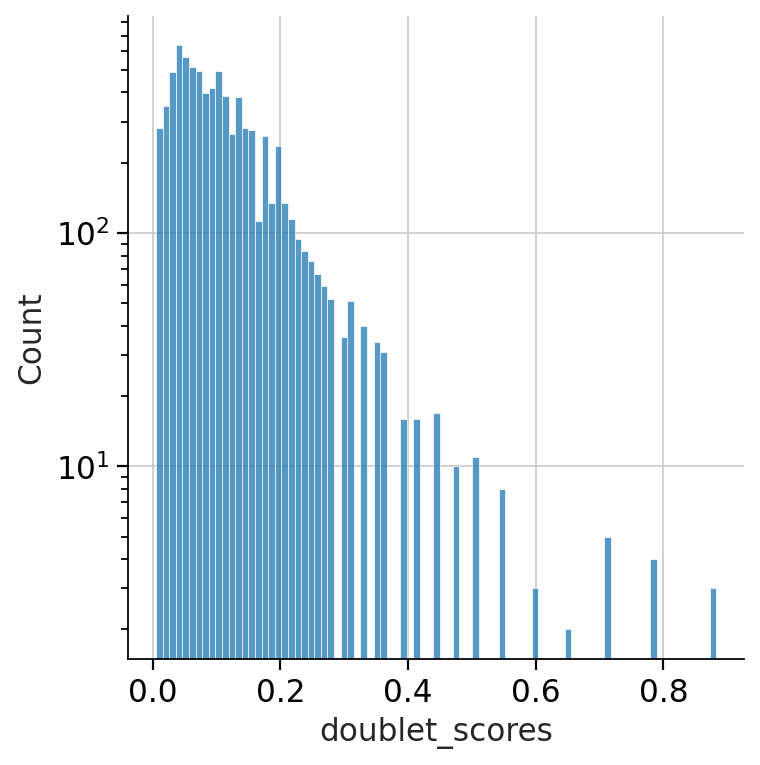

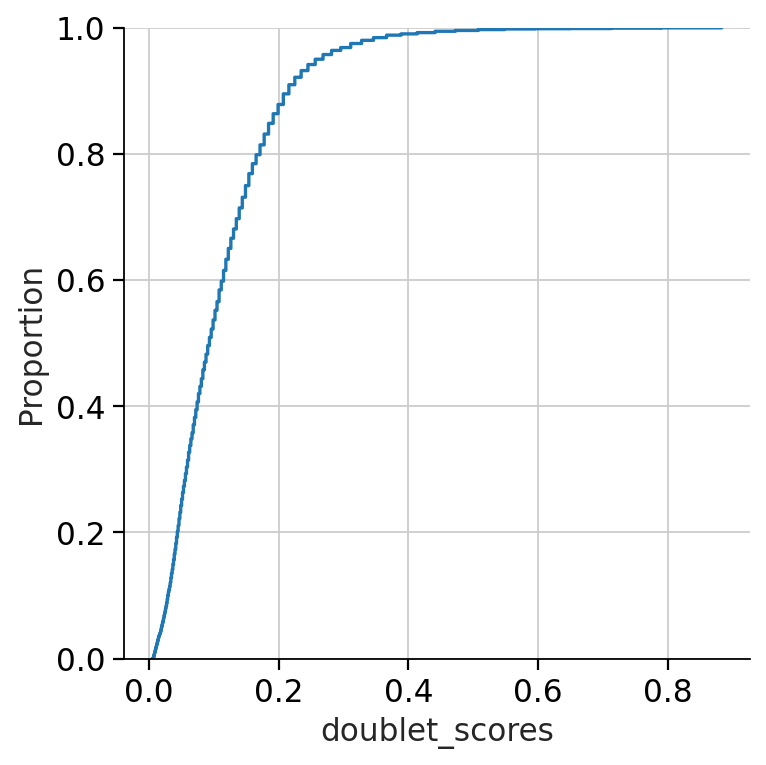

In [9]:
sns.displot(data = adata.obs, x = 'doublet_scores')
plt.yscale('log')

sns.displot(data = adata.obs, x = 'doublet_scores', kind = 'ecdf')

In [10]:
adata.obs.predicted_doublets = adata.obs['doublet_scores'] > 0.3
adata.obs.predicted_doublets = adata.obs['predicted_doublets'].astype(str)

In [11]:
## Technical UMAPs

... storing 'cb' as categorical
... storing 'sample_uid_vdj' as categorical
... storing 'cb_vdj' as categorical
... storing 'locus' as categorical
... storing 'vdjc_info' as categorical
... storing 'vdj_sequence' as categorical
... storing 'c_call' as categorical
... storing 'stop_codon' as categorical
... storing 'vj_in_frame' as categorical
... storing 'productive' as categorical
... storing 'v_call' as categorical
... storing 'd_call' as categorical
... storing 'j_call' as categorical
... storing 'sequence_alignment' as categorical
... storing 'germline_alignment' as categorical
... storing 'sequence_alignment_aa' as categorical
... storing 'germline_alignment_aa' as categorical
... storing 'v_sequence_alignment' as categorical
... storing 'v_sequence_alignment_aa' as categorical
... storing 'v_germline_alignment' as categorical
... storing 'v_germline_alignment_aa' as categorical
... storing 'd_sequence_alignment' as categorical
... storing 'd_sequence_alignment_aa' as categorical


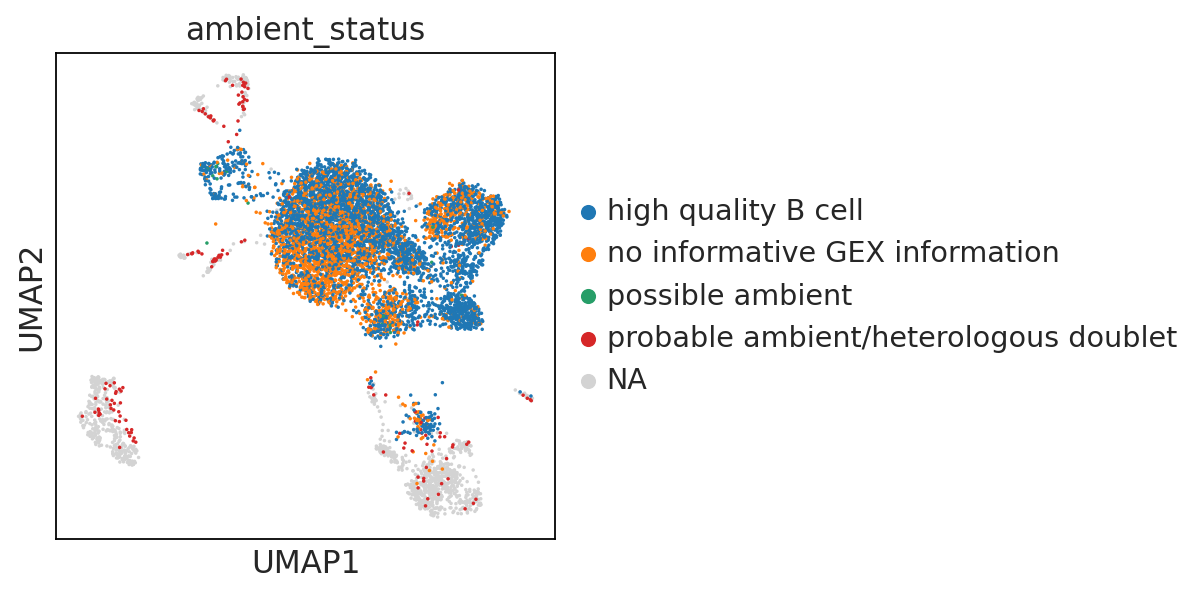

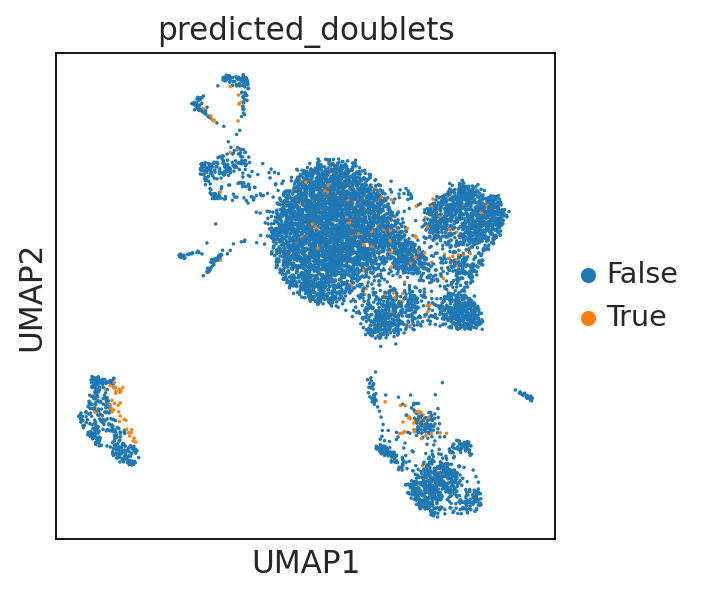

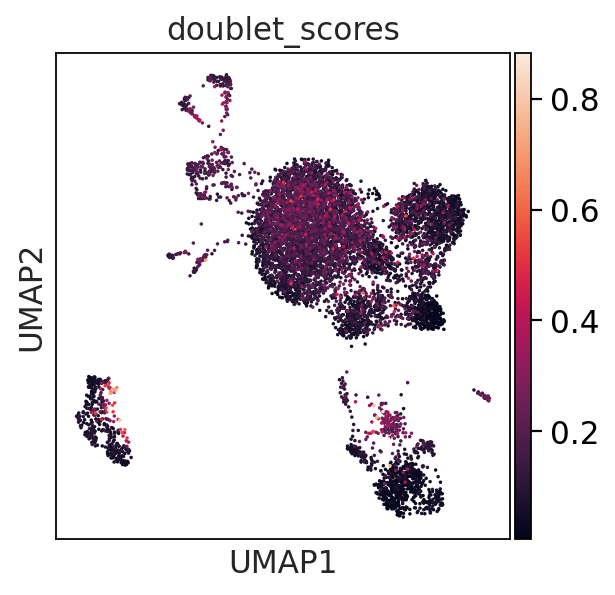

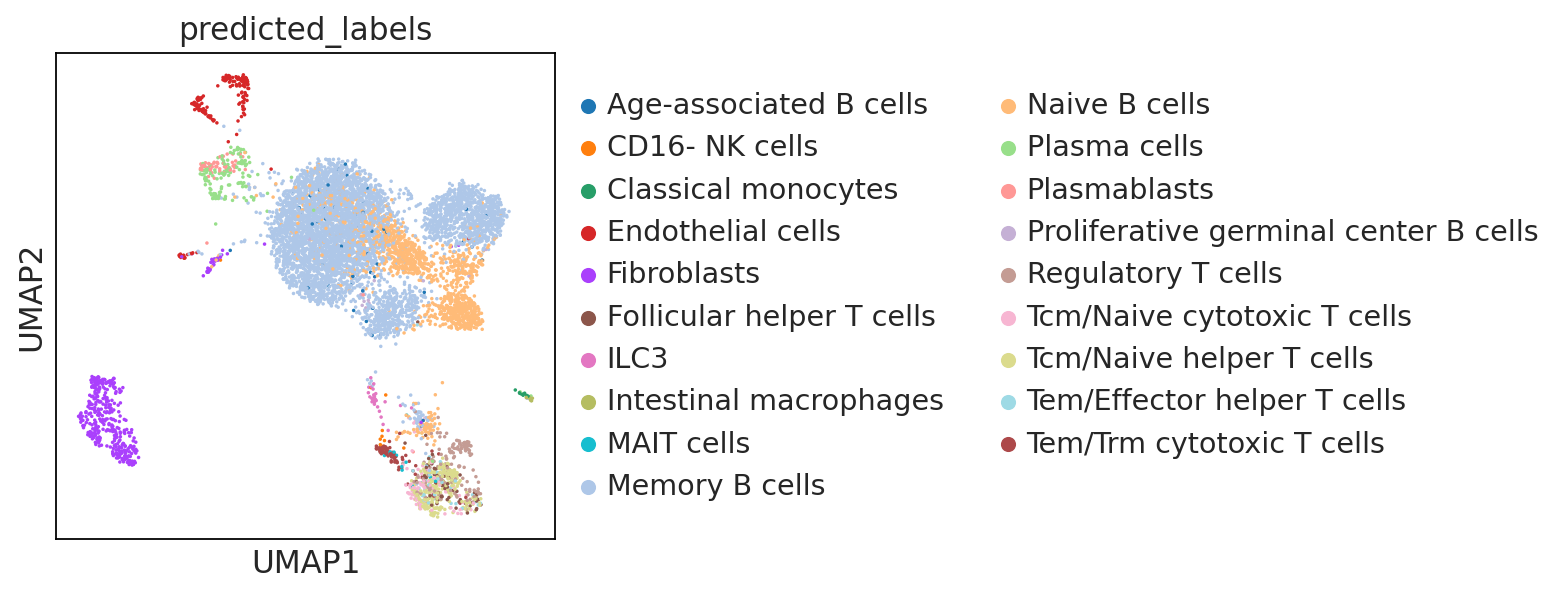

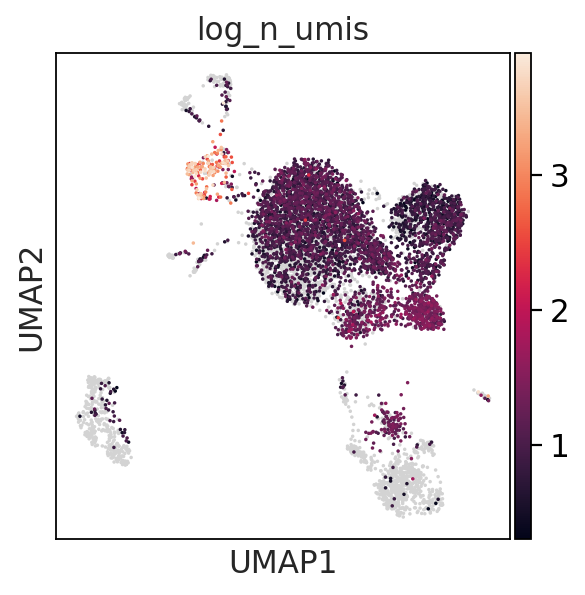

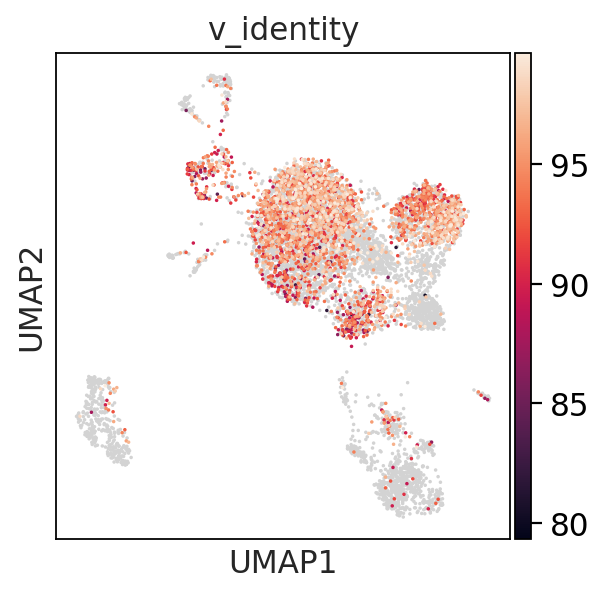

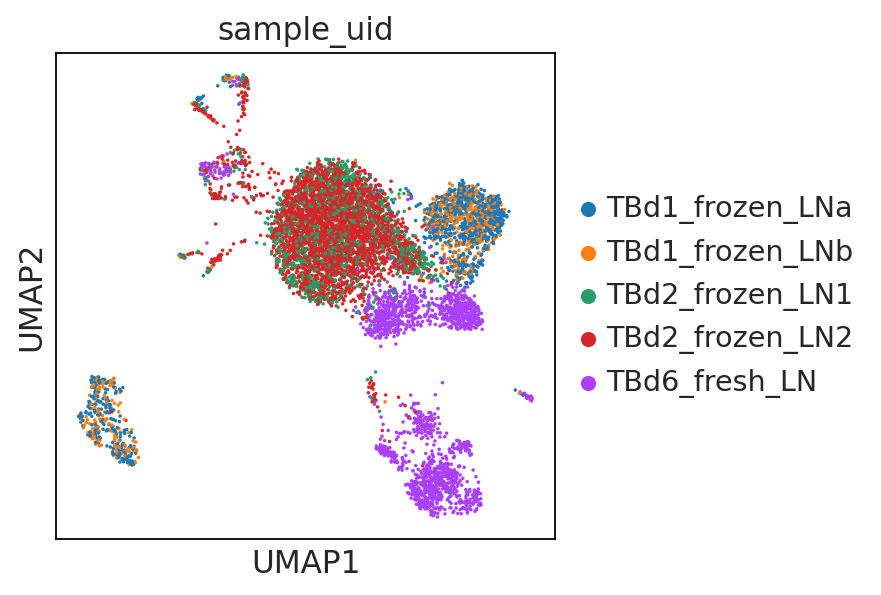

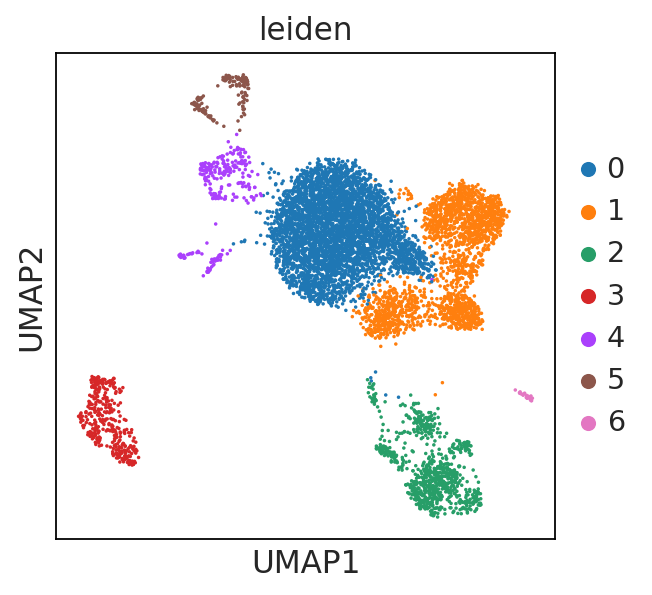

In [12]:
variables = ['ambient_status', 'predicted_doublets', 'doublet_scores', 'predicted_labels', "log_n_umis", 'v_identity', 'sample_uid', 'leiden']
for var in variables:
    sc.pl.umap(adata, color = var, size = 10, save = "{}_{}".format(var, tissue))

# doublet DE

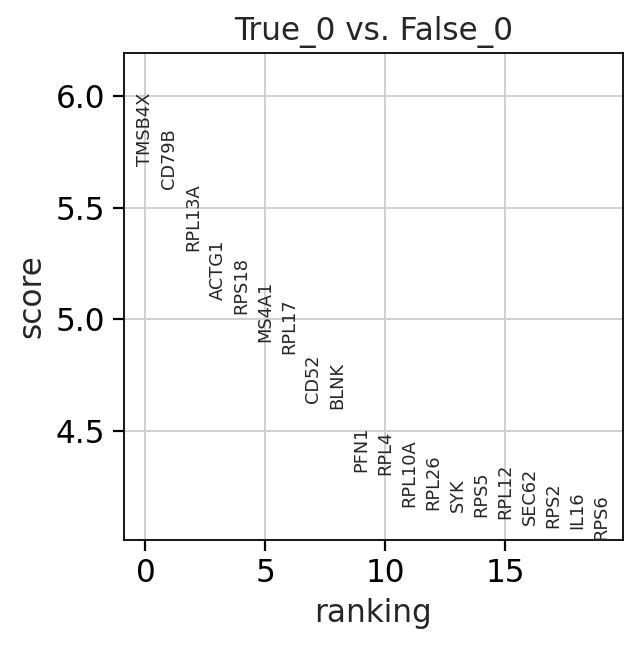

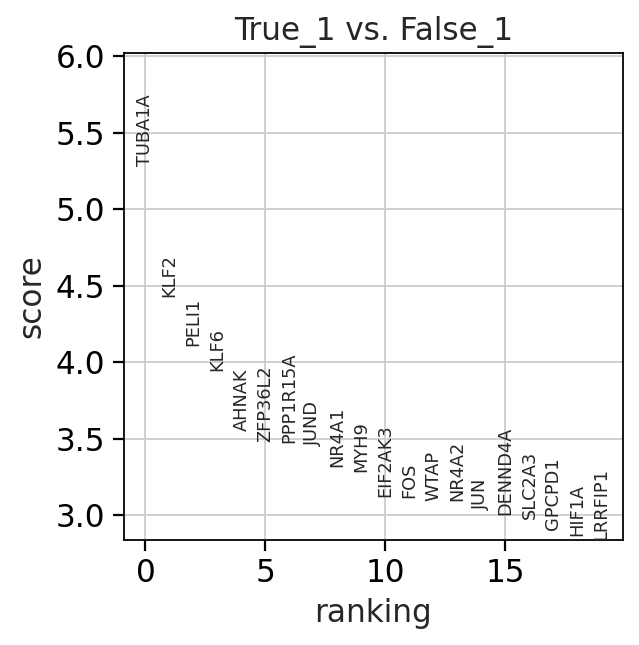

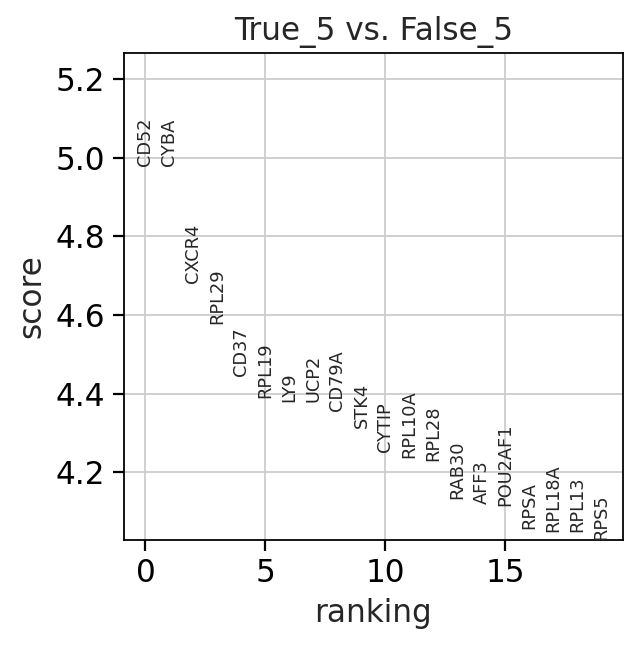

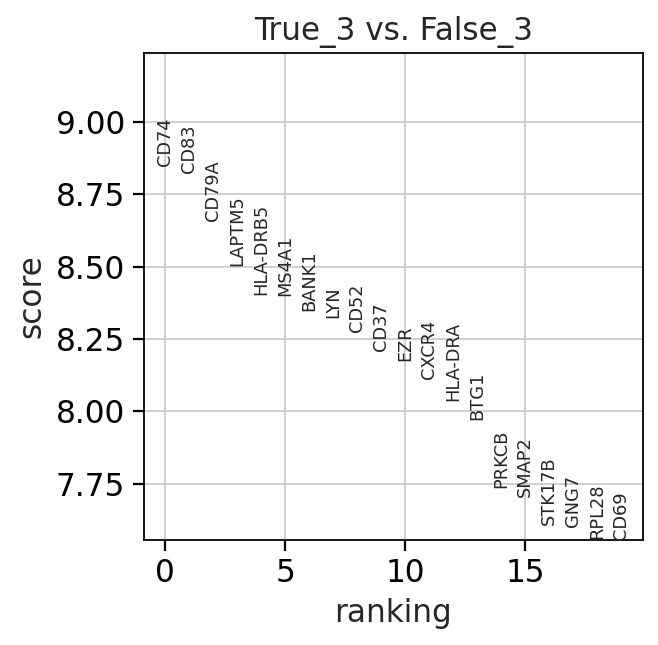

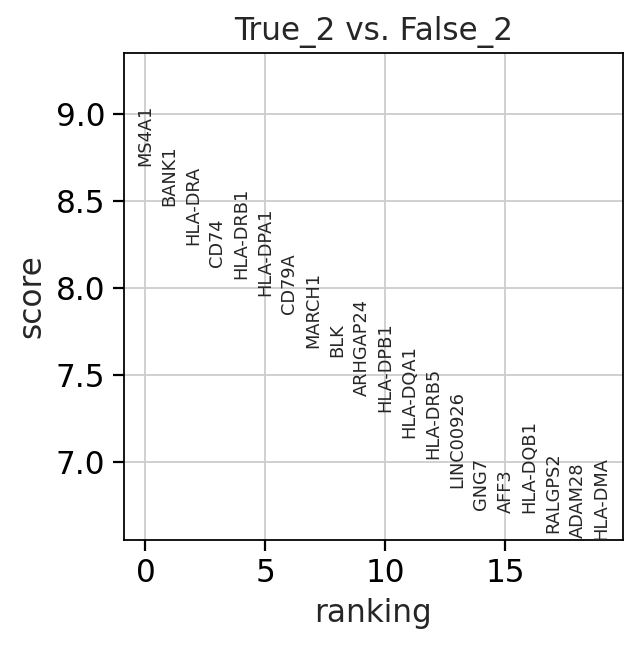

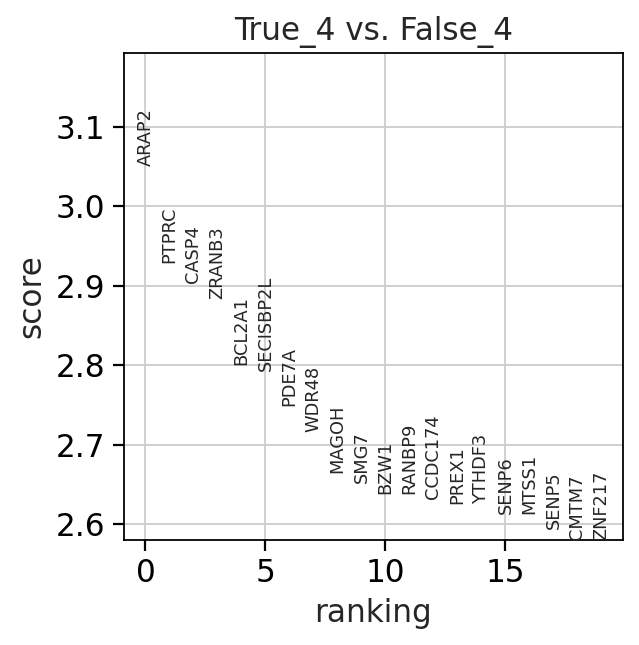

In [13]:
label = 'predicted_labels'
label = 'leiden'
classification = "predicted_doublets"
hybrid_class = "{}_celltype".format(classification)
adata.obs[hybrid_class] = adata.obs[classification].astype(str) + "_" + adata.obs[label].astype(str)
adata.obs[hybrid_class] = adata.obs[hybrid_class].map(lambda x: 'na' if x.startswith('na') else x)
adata.obs[hybrid_class] = adata.obs[hybrid_class].astype('category')

cell_group = hybrid_class
filter_low_abundance_cell_groups = False

# remove the dual labels
adata.obs.majority_voting = adata.obs.majority_voting.str.split("|", expand = True).iloc[:,0].astype('category')
if filter_low_abundance_cell_groups:
    select = adata.obs[cell_group].value_counts() > 5
    adata = adata[adata.obs[cell_group].isin(select[select == True].index)]

adata.obs.loc[:,label] = adata.obs[label].cat.remove_unused_categories()

d = adata.obs[hybrid_class][adata.obs[classification] == 'True'].str.split("_", expand = True).iloc[:,1].unique()

adata.uns['log1p']['base'] = np.e
marker_genes = {}
rank_genes_groups = {}
for celltype in d:
    sc.tl.rank_genes_groups(adata, groupby=hybrid_class, method='wilcoxon', reference='False_'+celltype, penalty = 'l2')
    sc.pl.rank_genes_groups(adata, groups=['True_'+celltype])
    marker_genes[celltype] = adata.uns['rank_genes_groups']['names']['True_'+celltype]
    rank_genes_groups[celltype] = adata.uns['rank_genes_groups']

['True_0', 'False_0']
['True_1', 'False_1']
['True_5', 'False_5']
['True_3', 'False_3']
['True_2', 'False_2']
['True_4', 'False_4']


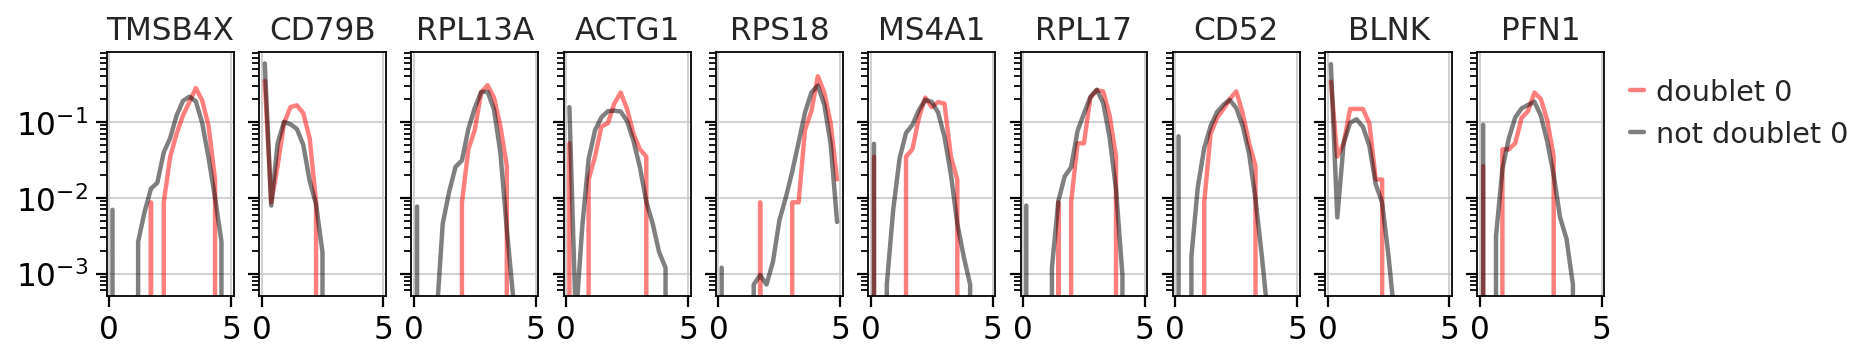

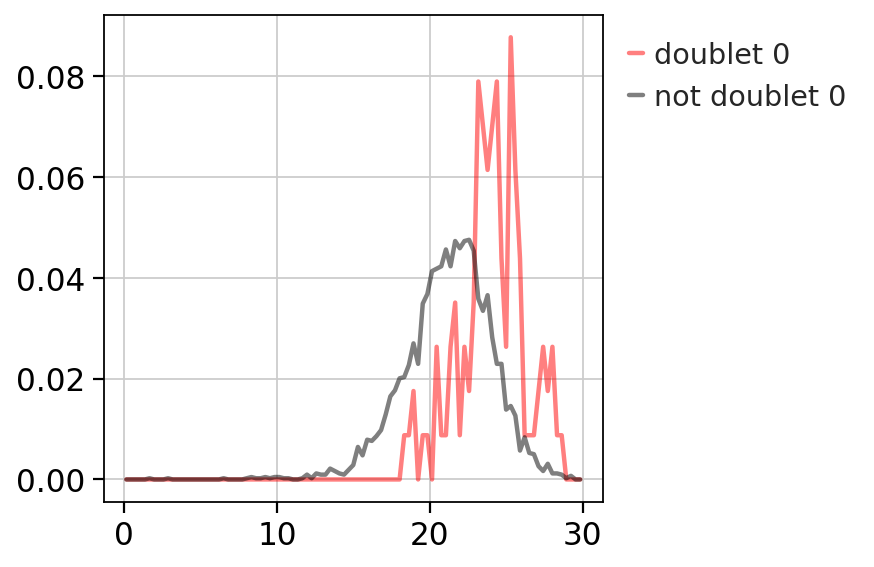

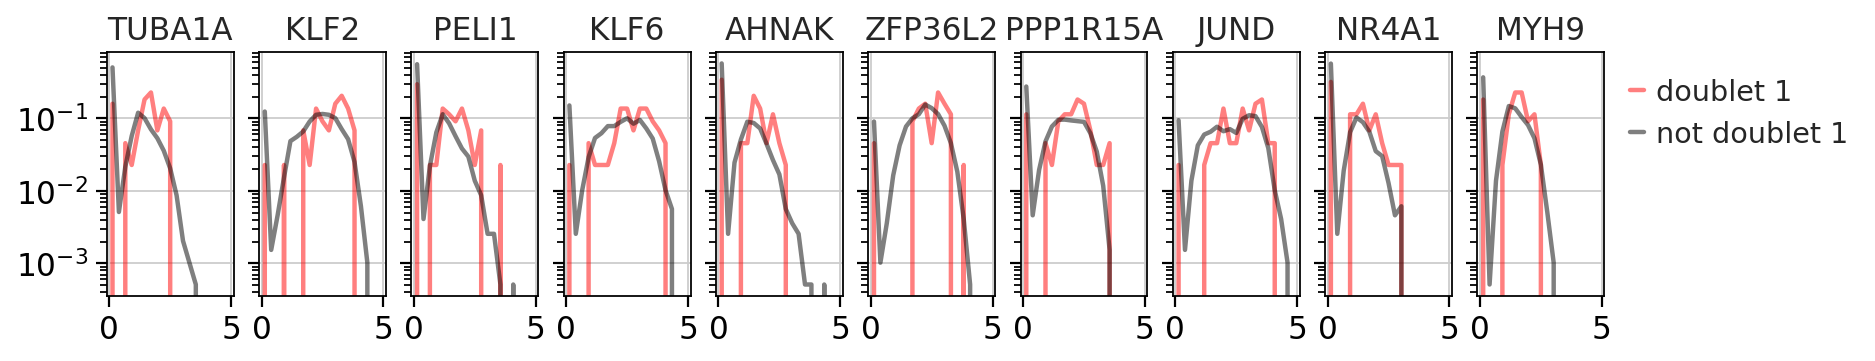

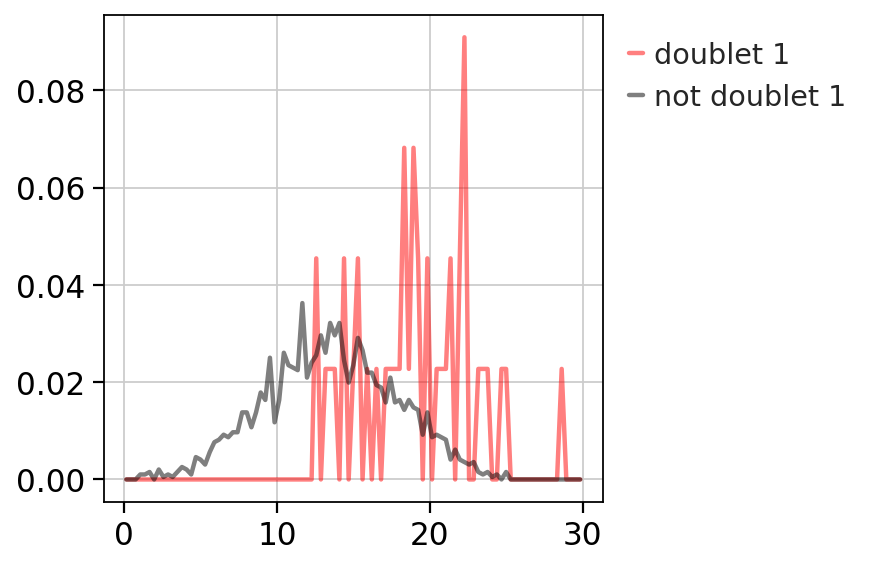

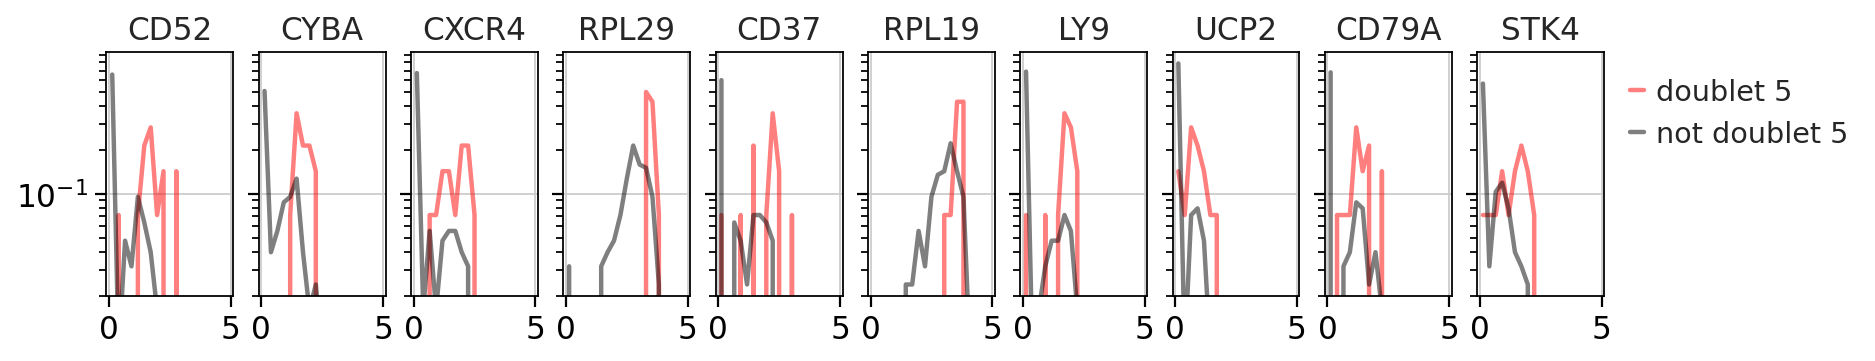

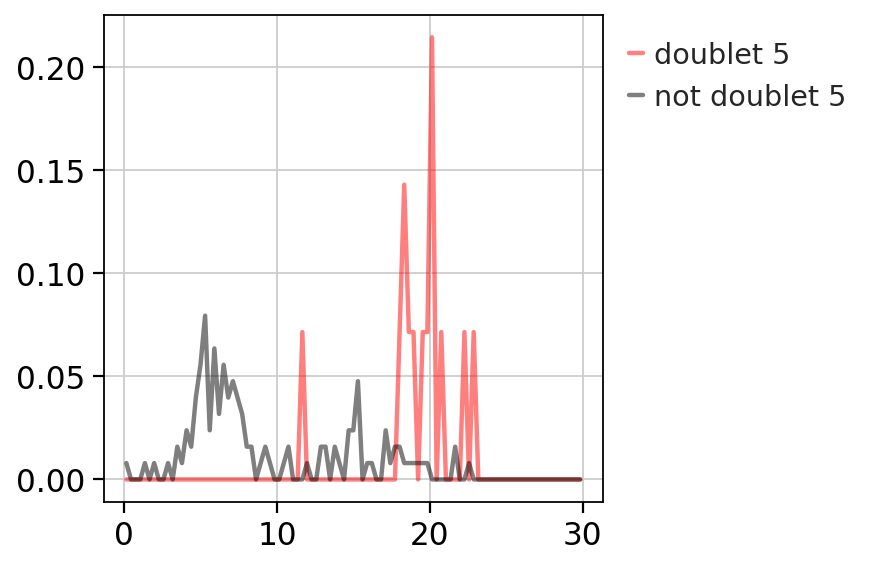

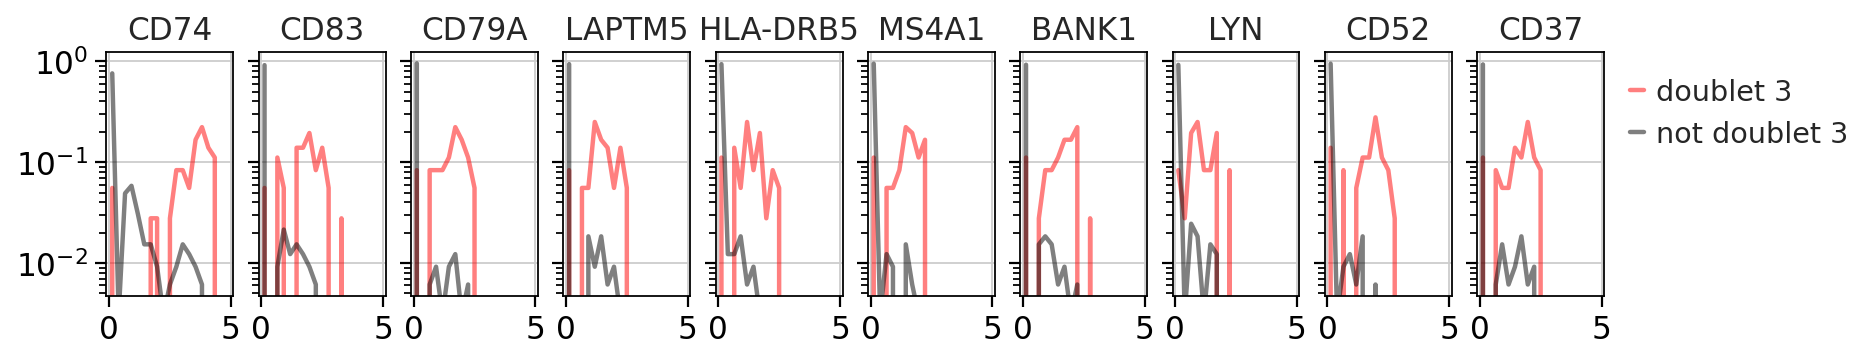

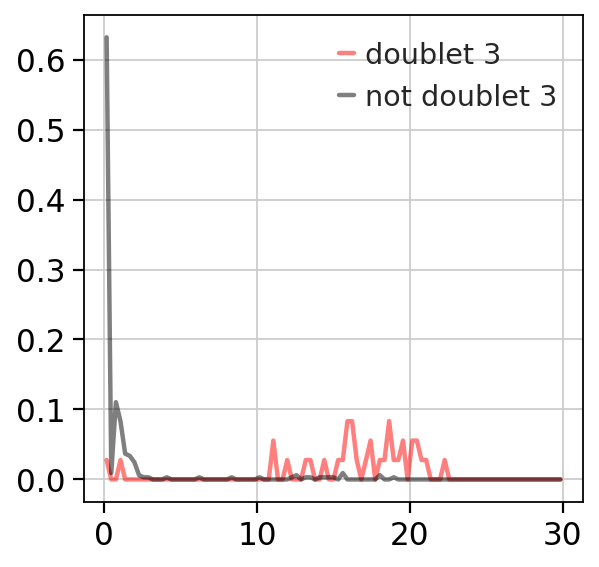

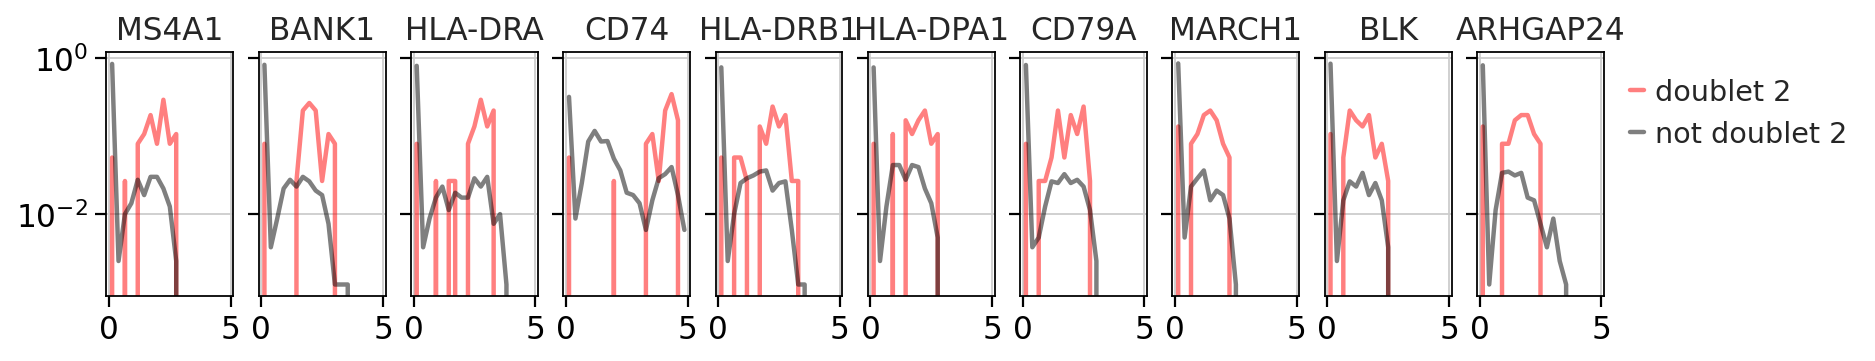

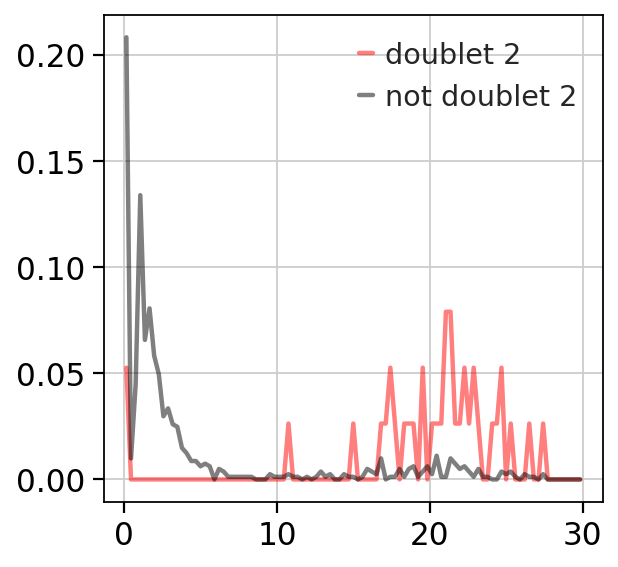

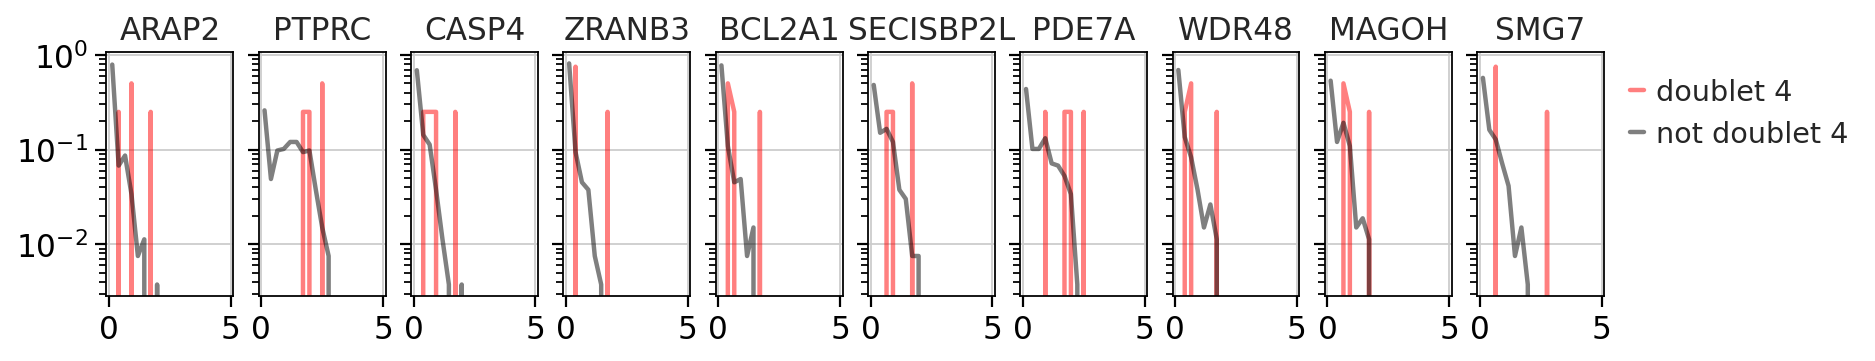

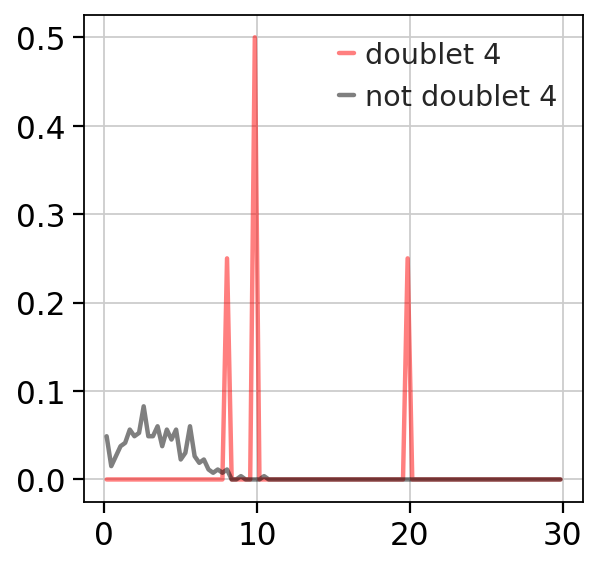

In [18]:
bins = np.linspace(0,5,20)
sum_obs_bins = np.linspace(0,30,100)

bin_centers = (bins[1:] + bins[:-1])/2.
sum_obs_bin_centers = (sum_obs_bins[1:] + sum_obs_bins[:-1])/2.

N_GENES_FOR_CLASSIFIER=100
NGENES = 10
not_cycling_color='k'
cycling_color='r'
color_kwargs = dict(lw=2, alpha=0.5)
all_obs_dfs = {}
for celltype in marker_genes.keys():
    obs_dfs = []
    groups=['True_'+celltype, 'False_'+celltype]
    print(groups)
    fig, ax = plt.subplots(1,NGENES, figsize=(12,2), sharey=True)
    fig_totals, ax_totals = plt.subplots(figsize=(4,4))
    sum_obs=None
    for i, gene in enumerate(marker_genes[celltype][:N_GENES_FOR_CLASSIFIER]):
        obs_df = sc.get.obs_df(adata, gene, use_raw=True)
        if sum_obs is None:
            sum_obs = pd.DataFrame({gene:obs_df})
        else:
            sum_obs = sum_obs.join(pd.DataFrame({gene:obs_df}))
        if i < NGENES:
            ax[i].set_title(gene)

            cycling = obs_df[adata.obs[hybrid_class]==groups[0]]
            not_cycling = obs_df[adata.obs[hybrid_class]==groups[1]]


            counts_cycling, bins = np.histogram(cycling, bins=bins)
            counts_not_cycling, bins = np.histogram(not_cycling, bins=bins)
            ax[i].plot(bin_centers, (counts_cycling)/np.sum(counts_cycling), label='doublet '+celltype,
                      color=cycling_color, **color_kwargs)
            ax[i].plot(bin_centers, (counts_not_cycling)/np.sum(counts_not_cycling), 
                       color = not_cycling_color, label='not doublet '+ celltype, **color_kwargs)
            ax[i].set_yscale('log')
            
    ax[-1].legend(loc='best', frameon=False, bbox_to_anchor=(1,1))
    fig.savefig('figures/{}_cycling_vs_not_cycling_genes.pdf'.format(celltype), bbox_inches='tight')
    i = i+1
    
    obs_dfs.append(sum_obs)
    cycling = sum_obs[adata.obs[hybrid_class]==groups[0]].iloc[:,:NGENES].sum(axis=1)
    not_cycling = sum_obs[adata.obs[hybrid_class]==groups[1]].iloc[:,:NGENES].sum(axis=1)


    counts_cycling, _ = np.histogram(cycling, bins=sum_obs_bins)
    counts_not_cycling, _ = np.histogram(not_cycling, bins=sum_obs_bins)
    ax_totals.plot(sum_obs_bin_centers, (counts_cycling)/np.sum(counts_cycling), label='doublet '+celltype,
              color=cycling_color, **color_kwargs)
    ax_totals.plot(sum_obs_bin_centers, (counts_not_cycling)/np.sum(counts_not_cycling), 
               color = not_cycling_color, label='not doublet '+ celltype, **color_kwargs)
#     ax_totals.set_yscale('log')
    ax_totals.legend(loc='best', frameon=False, bbox_to_anchor=(1,1))
    all_obs_dfs.update({celltype: pd.concat(obs_dfs)})

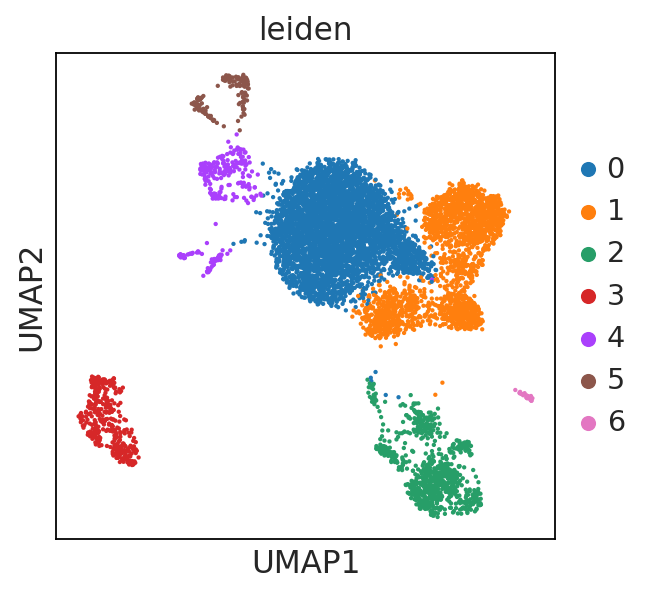

In [17]:
sc.pl.umap(adata, color = 'leiden')

## umis by celltype

In [ ]:
data = adata.obs[adata.obs.predicted_labels.str.contains("Naive B|Memory|Plasma")]
data.predicted_labels.cat.remove_unused_categories(inplace = True)
hue = 'predicted_labels'
kind = 'ecdf'
x = "n_umis"
g = sns.displot(data = data, x = x, kind = kind, log_scale=True, hue = hue)
save_figure(g.fig, "{}_n_umis_{}".format(x,kind,hue))

In [ ]:
gene = "IGKC"

_umi = sc.get.obs_df(adata, keys = gene, layer='umi_counts')
_bg = sc.get.obs_df(adata, keys = gene, layer='background_removed')

data = pd.concat([_bg, _umi], axis=1)

data.columns = ['cbender', 'umi']

data = data.melt()

sns.displot(data, x = 'value', hue = 'variable', kind = 'ecdf', log_scale=True)

gene = "CD3E"

_umi = sc.get.obs_df(adata, keys = gene, layer='umi_counts')
_bg = sc.get.obs_df(adata, keys = gene, layer='background_removed')

data = pd.concat([_bg, _umi], axis=1)

data.columns = ['cbender', 'umi']

data = data.melt()

sns.displot(data, x = 'value', hue = 'variable', kind = 'ecdf', log_scale=True)

In [ ]:
sc.tl.leiden(adata, key_added='{}_leiden'.format(tissue))

In [ ]:
sc.tl.rank_genes_groups(adata, groupby='{}_leiden'.format(tissue))
sc.pl.rank_genes_groups(adata)

In [ ]:
adata.obs['B_cell'] = adata.obs.predicted_labels.str.contains('B cell|Plasma|B-')

In [ ]:
df = adata.obs[['sample_uid', 'majority_voting', 'n_genes', 'total_counts', 'total_counts_mt', '{}_leiden'.format(tissue), 'tissue', ]]

In [ ]:
df.to_csv('{}_obs.tab'.format(tissue), sep = '\t')

## Filter Leiden groups which appear to be other celltypes

In [ ]:
data = pd.DataFrame(adata.obs.groupby('sample_uid').B_cell.value_counts(normalize = True))

In [ ]:
data.columns = ['fraction_b_cells']

In [ ]:
data = data.reset_index()

In [ ]:
data[data.B_cell]

In [ ]:
file_name = "{}_bcell_fraction.tab".format(tissue)
data.to_csv(file_name, sep = '\t')

In [ ]:
cell_group = 'leiden'
bcells = adata[adata.obs[cell_group].isin(['0', '2', '5', '6'])]
